In [1]:
import os
import qiime2 as q2
import pandas as pd
import numpy as np
from biom.util import biom_open
from subprocess import check_call
from scipy.spatial import distance
from biom import load_table, Table
from skbio import OrdinationResults
from assets.step_wise_anova import run_stepwise_anova
from skbio.stats.distance import permanova, anosim
from skbio.stats.distance import DistanceMatrix
from qiime2.plugins.gemelli.actions import ctf
from qiime2.plugins.diversity.actions import (beta,
                                              beta_phylogenetic,
                                              pcoa)
from qiime2.plugins.diversity.actions import beta_group_significance

# stats tests
from scipy.linalg import norm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import wilcoxon, ttest_ind, f_oneway, ttest_rel
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)

# plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import to_hex

# warnings filter 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None  # default='warn'

plt.style.use('ggplot')
%matplotlib inline

In [2]:
def temporal_plot(x_axis, y_axis, df, ax, title, x_label, y_label,
                  title_fontsize, x_fontsize, y_fontsize, hue=None,
                  style=None, size=None, min_x = 0, max_x = 35, err_style='band', 
                  ci=95, cmap='tab10', style_order=None, dashes_=True,
                  style_order_ = ['CSseed','Vag','CS']):

    """

    This wrapper creates beautiful timeseries plots using
    seaborn and matplotlib. 

    Parameters
    ----------
    x_axis : str, required
        X-axis catagory in dataframe -- data
        
    y_axis : str, required
        y-axis catagory in dataframe -- data
        
    df : dataframe, required
        dataframe of data to plot
    
    ax : matplotlib figure object, required
        panel object from matplotlib figure 
    
    title : str, required
        panel title
    
    x_label : str, required
        x label panel title
    
    y_label : str, required
        y label panel title
        
    title_fontsize : int, required
    x_fontsize : int, required
    y_fontsize : int, required
        font sizes 
    
    hue : str, optional
        color by catagory in dataframe -- data
        
    style : str, optional
        style by catagory in dataframe -- data
    
    Returns
    ----------
    matplotlib figure object

    """
    

    # Lineplot across time 
    sns.lineplot(x=x_axis,
                 y=y_axis,
                 hue=hue,
                 style=style,
                 dashes=dashes_,
                 style_order=style_order_,
                 ci=ci,
                 sort=True,
                 markers=style_order,
                 estimator=np.mean,
                 err_style=err_style,
                 palette=cmap,
                 data=df,
                 ax=ax)
    
    
    
    ax.set_title(title, fontsize=title_fontsize)
    ax.set_xlabel(x_label, color='#000000',
                  fontsize=x_fontsize)
    ax.set_ylabel(y_label, color='#000000',
                  fontsize=y_fontsize, labelpad=0)
    
    # remove all grids, backrounds etc ...
    ax.legend_.remove()        
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_bounds(min_x, max_x)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('grey')

    return ax

### plot ordination

In [3]:
sub_trajs = {}
subord = {}

sub_trajs['fecal'] = q2.Artifact.load('../data/ctf-results/fecal/state_subject_ordination.qza')
sub_trajs['fecal'] = sub_trajs['fecal'].view(q2.Metadata).to_dataframe()
subord['fecal'] = q2.Artifact.load('../data/ctf-results/fecal/subject_biplot.qza').view(OrdinationResults)

sub_trajs['skin'] = q2.Artifact.load('../data/ctf-results/skin/state_subject_ordination.qza')
sub_trajs['skin'] = sub_trajs['skin'].view(q2.Metadata).to_dataframe()
subord['skin'] = q2.Artifact.load('../data/ctf-results/skin/subject_biplot.qza').view(OrdinationResults)

sub_trajs['oral'] = q2.Artifact.load('../data/ctf-results/oral/state_subject_ordination.qza')
sub_trajs['oral'] = sub_trajs['oral'].view(q2.Metadata).to_dataframe()
subord['oral'] = q2.Artifact.load('../data/ctf-results/oral/subject_biplot.qza').view(OrdinationResults)


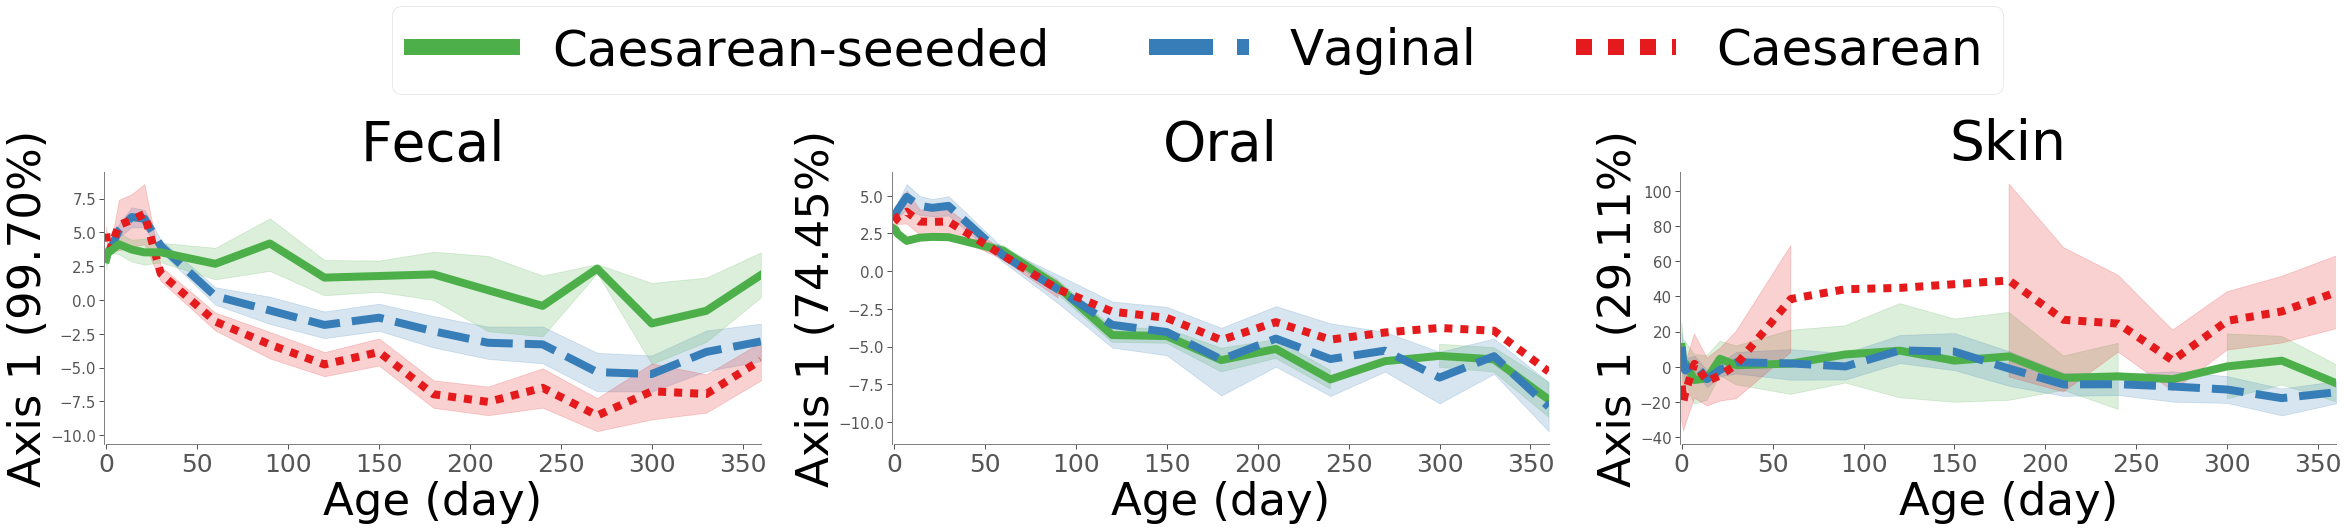

In [4]:
# set label font-sizes globally
paper_rc = {'lines.linewidth': 8, 
            'lines.markersize': 10}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 25 
plt.rcParams['ytick.labelsize'] = 15

fig, axn = plt.subplots(1,3, figsize=(40,5))

color_by = 'birth_mode_ms'
time_ = 'date_sampling_category_days_continuous'
cmap_bm = {'CS':'#e41a1c',
           'CSseed':'#4daf4a',
           'Vag':'#377eb8'}

stypes = ['fecal','oral','skin']
for stype_, ax, value_y in zip(stypes, axn.flatten(), ['PC1','PC1','PC1']):
    
    sub_trajs_plot = sub_trajs[stype_].copy()
    sub_trajs_plot = sub_trajs_plot[sub_trajs_plot.country.isin(['USA'])]
    propexp = subord[stype_].proportion_explained
    PC_label = 'Axis 1' + ' (%.2f%%)'%(propexp[0]*100)
    
    ax = temporal_plot(time_, value_y, sub_trajs_plot, ax,
                       stype_.capitalize(), 'Age (day)', PC_label, 55, 45, 45,
                       hue=color_by, style=color_by, min_x=0,
                       max_x = 360.0,
                       ci=68, cmap=cmap_bm)
    ax.set_xlim(-1.0, 360.0)

# generate legend from last iterations  
fix_labels = {'Vag':'Vaginal', 'CS':'Caesarean', 'CSseed':'Caesarean-seeeded'}
# generate legend from last iterations
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[1:], [fix_labels[l] for l in labels[1:]], loc=2,
                         bbox_to_anchor=(-2.0, 1.7),
                         prop={'size':50},
                         fancybox=True, framealpha=0.5, 
                         ncol=3, markerscale=3, facecolor="white")
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(16.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(16.0)
# set the backrounf to be transparent
fig.patch.set_facecolor('white')
fig.patch.set_alpha(0.0)

plt.savefig('../results/Extended-Data-Figure-3.pdf',dpi=1000,
            bbox_inches='tight',
            facecolor=fig.get_facecolor(),
            edgecolor='none')

plt.show()

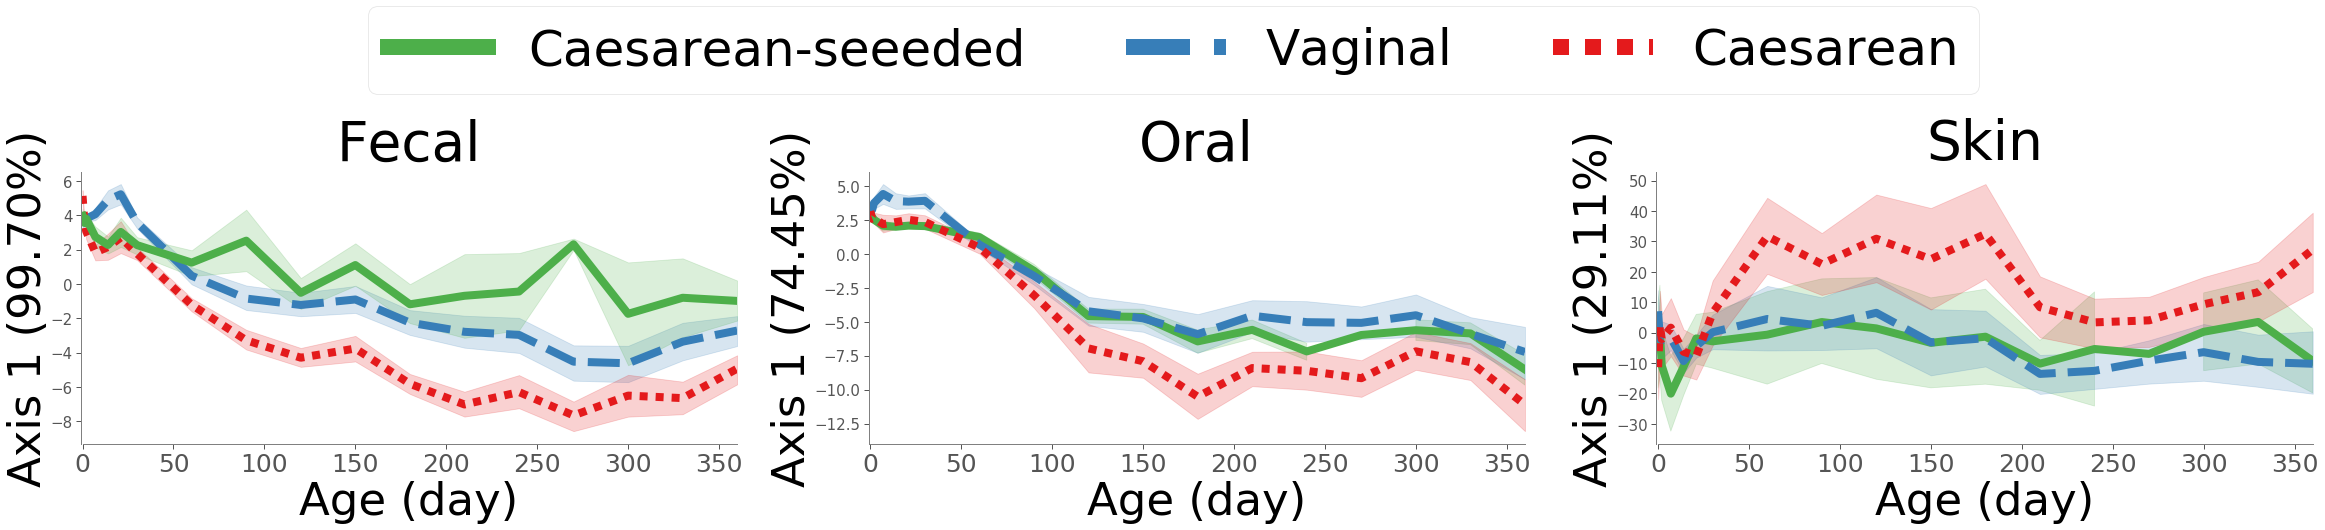

In [9]:
# set label font-sizes globally
paper_rc = {'lines.linewidth': 8, 
            'lines.markersize': 10}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 25 
plt.rcParams['ytick.labelsize'] = 15

fig, axn = plt.subplots(1,3, figsize=(40,5))

color_by = 'birth_mode_ms'
time_ = 'date_sampling_category_days_continuous'
cmap_bm = {'CS':'#e41a1c',
           'CSseed':'#4daf4a',
           'Vag':'#377eb8'}

stypes = ['fecal','oral','skin']
for stype_, ax, value_y in zip(stypes, axn.flatten(), ['PC1','PC1','PC1']):
    
    sub_trajs_plot = sub_trajs[stype_].copy()
    propexp = subord[stype_].proportion_explained
    PC_label = 'Axis 1' + ' (%.2f%%)'%(propexp[0]*100)
    
    ax = temporal_plot(time_, value_y, sub_trajs_plot, ax,
                       stype_.capitalize(), 'Age (day)', PC_label, 55, 45, 45,
                       hue=color_by, style=color_by, min_x=0,
                       max_x = 360.0,
                       ci=68, cmap=cmap_bm)
    ax.set_xlim(-1.0, 360.0)
    
# generate legend from last iterations  
fix_labels = {'Vag':'Vaginal', 'CS':'Caesarean', 'CSseed':'Caesarean-seeeded'}
# generate legend from last iterations
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[1:], [fix_labels[l] for l in labels[1:]], loc=2,
                         bbox_to_anchor=(-2.0, 1.7),
                         prop={'size':50},
                         fancybox=True, framealpha=0.5, 
                         ncol=3, markerscale=3, facecolor="white")
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(16.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(16.0)
# set the backrounf to be transparent
fig.patch.set_facecolor('white')
fig.patch.set_alpha(0.0)

plt.savefig('../results/Figure-1a.pdf',dpi=1000,
            bbox_inches='tight',
            facecolor=fig.get_facecolor(),
            edgecolor='none')

plt.show()

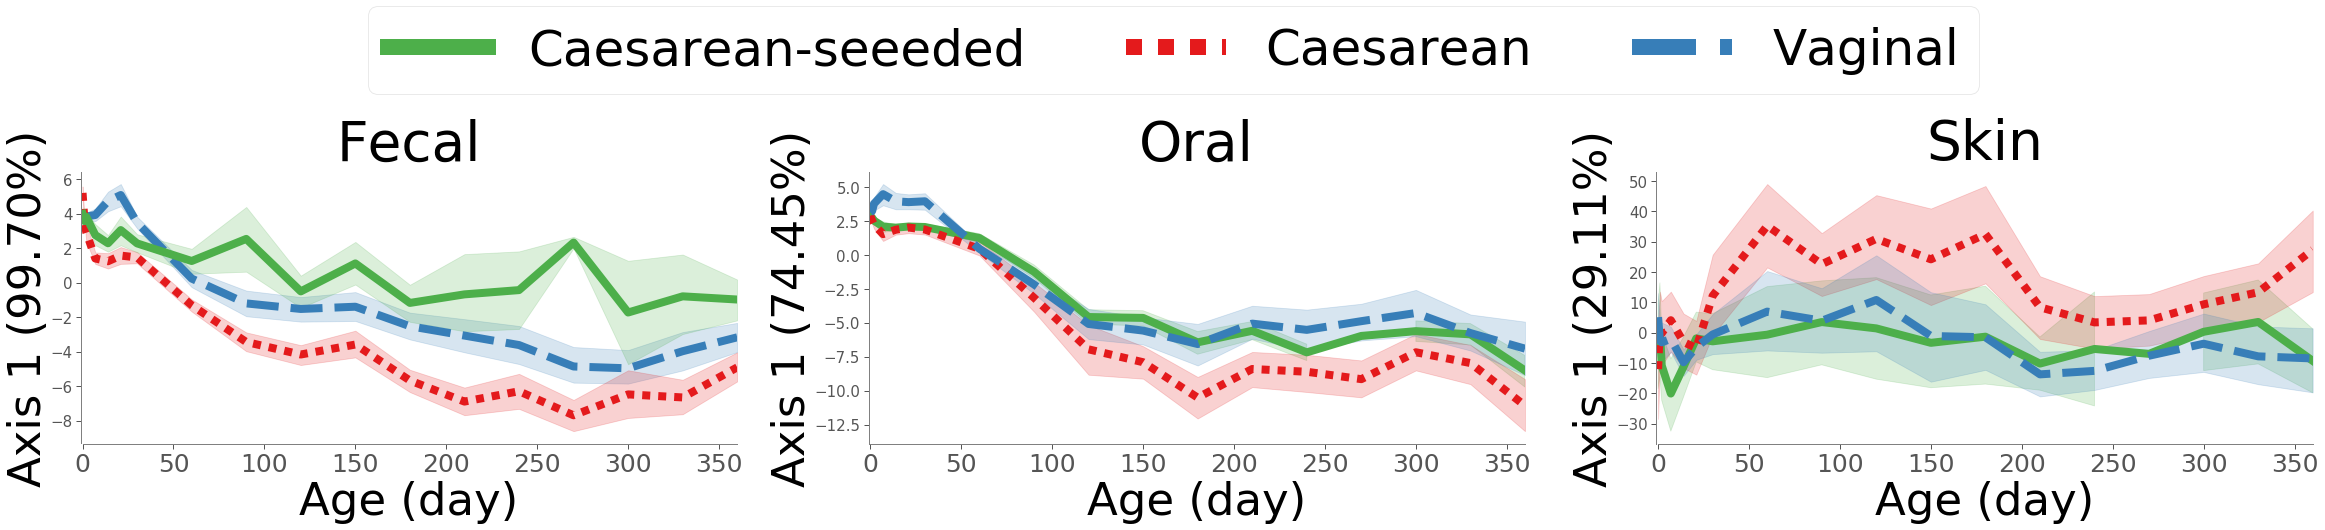

In [8]:
# set label font-sizes globally
paper_rc = {'lines.linewidth': 8, 
            'lines.markersize': 10}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 25 
plt.rcParams['ytick.labelsize'] = 15

fig, axn = plt.subplots(1,3, figsize=(40,5))

color_by = 'birth_mode_ms'
time_ = 'date_sampling_category_days_continuous'
cmap_bm = {'CS':'#e41a1c',
           'CSseed':'#4daf4a',
           'Vag':'#377eb8'}

stypes = ['fecal','oral','skin']
for stype_, ax, value_y in zip(stypes, axn.flatten(), ['PC1','PC1','PC1']):
    
    sub_trajs_plot = sub_trajs[stype_].copy()
    sub_trajs_plot = sub_trajs_plot[sub_trajs_plot['mother_prenatal_gbs'] != 'Yes']
    propexp = subord[stype_].proportion_explained
    PC_label = 'Axis 1' + ' (%.2f%%)'%(propexp[0]*100)
    
    ax = temporal_plot(time_, value_y, sub_trajs_plot, ax,
                       stype_.capitalize(), 'Age (day)', PC_label, 55, 45, 45,
                       hue=color_by, style=color_by, min_x=0,
                       max_x = 360.0,
                       ci=68, cmap=cmap_bm)
    ax.set_xlim(-1.0, 360.0)
    
# generate legend from last iterations  
fix_labels = {'Vag':'Vaginal', 'CS':'Caesarean', 'CSseed':'Caesarean-seeeded'}
# generate legend from last iterations
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[1:], [fix_labels[l] for l in labels[1:]], loc=2,
                         bbox_to_anchor=(-2.0, 1.7),
                         prop={'size':50},
                         fancybox=True, framealpha=0.5, 
                         ncol=3, markerscale=3, facecolor="white")
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(16.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(16.0)
# set the backrounf to be transparent
fig.patch.set_facecolor('white')
fig.patch.set_alpha(0.0)

plt.savefig('../results/GBS-neg-CTF-PC1-plots.pdf',dpi=1000,
            bbox_inches='tight',
            facecolor=fig.get_facecolor(),
            edgecolor='none')

plt.show()

### Effect Size

In [8]:
%%capture

keep_ = {'fecal':['date_sampling_category_days_continuous',
                 'prep_name','birth_mode_ms','country',
                 'mother_prenatal_gbs','current_abx','subjectid_unique',
                  'current_solids','baby_sex','current_formula'
                 'current_breast_feeding','mother_abx_perinatal',
                  'ever_abx','ever_breast_feeding','ever_formula'],
         'oral':['date_sampling_category_days_continuous',
                 'prep_name','birth_mode_ms','country',
                 'mother_prenatal_gbs','current_abx','subjectid_unique',
                  'current_solids','baby_sex','current_formula'
                 'current_breast_feeding','mother_abx_perinatal',
                  'ever_abx','ever_breast_feeding','ever_formula'],
         'skin':['date_sampling_category_days_continuous',
                 'prep_name','birth_mode_ms','country',
                 'mother_prenatal_gbs','current_abx','subjectid_unique',
                  'current_solids','baby_sex','current_formula'
                 'current_breast_feeding','mother_abx_perinatal',
                  'ever_abx','ever_breast_feeding','ever_formula']}
stypes = ['fecal','skin','oral']
es = {}
for stype_ in stypes:
    sub_trajs_plot = sub_trajs[stype_].copy()
    sub_trajs_plot[sub_trajs_plot == 'nan'] = np.nan
    sub_trajs_plot.columns = [col_.replace('old_','')
                              for col_ in sub_trajs_plot.columns] 
    pc_cols = [col_ for col_ in sub_trajs_plot.columns
               if 'PC' in col_][:]
    metcols = [col_ for col_ in sub_trajs_plot.columns
               if 'PC' not in col_]
    metcols_ = list(set(keep_[stype_]) & set(metcols))
    sub_trajs_plot = sub_trajs_plot.loc[sub_trajs_plot[metcols_].dropna(0).index, :]
    es[stype_] = run_stepwise_anova(sub_trajs_plot[pc_cols],
                                    sub_trajs_plot[metcols_],
                                    metcols_)


In [9]:
rename_ = {'+ baby_sex':'Sex',
           '+ birth_mode_ms':'Birth mode',
           '+ current_abx':'ABX Current',
           '+ date_sampling_category_days_continuous':'Time (days)',
           '+ subjectid_unique':'Subject ID',
           '+ mother_abx_perinatal':'Maternal Prenatal ABX',
           '+ mother_prenatal_gbs':'Maternal Prenatal GBS',
           '+ country':'Country of Birth',
           '+ prep_name':'Sequencing Lane-Run',
           '+ current_solids':'Solid Food',
           '+ ever_breast_feeding':'Breastmilk dominant',
           '+ ever_formula':'Formula dominant',
           '+ ever_abx':'ABX Ever',
           '<All variables>':'All Others Aggergated'}

esdf = pd.concat(es).rename(rename_).fillna('-')
esdf = esdf.rename({'R2.adj':'Effect Size'}, axis=1)
esdf.index.names = ['body-site','metadata-column(s)']
esdf.to_csv('../results/Extended-Data-Table-3.tsv', sep='\t')
esdf


Effect Size  Df         AIC           F  \
body-site metadata-column(s)                                               
fecal     Country of Birth          0.220808   2  545.577389   91.398268   
          Time (days)               0.108322   1  450.925194  103.691509   
          Birth mode                0.048443   2  405.017405   25.710552   
          Sequencing Lane-Run       0.013212   1  392.297457   14.727678   
          Solid Food                0.004495   1  388.553415    5.697699   
          Sex                       0.003934   1  385.369508    5.131682   
          ABX Current               0.002080   2  385.121636    2.094327   
skin      Time (days)               0.090756   1  952.102219   56.796577   
          Country of Birth          0.074913   3  906.932611   17.700623   
          Birth mode                0.035049   2  884.877754   13.168554   
          Sex                       0.023138   1  869.413430   17.486079   
          Sequencing Lane-Run       0.020460   1  855.437836   15.945203   
          Maternal Prenatal GBS     0.008543   1  850.053931    7.300071   
          Maternal Prenatal ABX     0.012875   1  841.300461   10.644111   
          ABX Current               0.004747   1  838.647202    4.572518   
oral      Time (days)               0.163999   1  722.676527  117.917740   
          Country of Birth          0.038469   3  697.535445   10.566618   
          Birth mode                0.014964   2  688.207154    6.660074   
          Sex                       0.009977   1  681.534647    8.618742   
          Sequencing Lane-Run       0.007276   1  676.871529    6.599429   
          Maternal Prenatal GBS     0.004461   2  675.347671    2.723620   
          Maternal Prenatal ABX     0.002570   1  674.308414    2.985761   
          ABX Current               0.002540   1  673.284283    2.965784   

                                   Pr(>F)  
body-site metadata-column(s)               
fecal     Country of Birth       0.000200  
          Time (days)            0.000200  
          Birth mode             0.000200  
          Sequencing Lane-Run    0.000200  
          Solid Food             0.001800  
          Sex                    0.004999  
          ABX Current            0.069586  
skin      Time (days)            0.000200  
          Country of Birth       0.000200  
          Birth mode             0.000200  
          Sex                    0.000200  
          Sequencing Lane-Run    0.000200  
          Maternal Prenatal GBS  0.001200  
          Maternal Prenatal ABX  0.000200  
          ABX Current            0.008598  
oral      Time (days)            0.000200  
          Country of Birth       0.000200  
          Birth mode             0.000200  
          Sex                    0.000400  
          Sequencing Lane-Run    0.000800  
          Maternal Prenatal GBS  0.020996  
          Maternal Prenatal ABX  0.037992  
          ABX Current            0.035593

## plot the ANOSIM stats

In [10]:
dists = {}

dists['fecal'] = [q2.Artifact.load('../data/ctf-results/fecal/distance_matrix.qza').view(DistanceMatrix),
                  q2.Metadata.load('../data/split-data/Baby-Feces/metadata.qza').to_dataframe()]
dists['skin'] = [q2.Artifact.load('../data/ctf-results/skin/distance_matrix.qza').view(DistanceMatrix),
                  q2.Metadata.load('../data/split-data/Baby-Right_Forearm/metadata.qza').to_dataframe()]
dists['oral'] = [q2.Artifact.load('../data/ctf-results/oral/distance_matrix.qza').view(DistanceMatrix),
                  q2.Metadata.load('../data/split-data/Baby-Mouth/metadata.qza').to_dataframe()]



In [11]:
for type_, v in dists.items():
    print(type_)
    mf_ = v[1].copy()

fecal
skin
oral


In [12]:

country_ = []
bmode_ = []
for type_, v in dists.items():
    print(type_)
    mf_ = v[1].copy()
    df1_ = mf_.groupby('host_subject_id').agg({'birth_mode_ms':'first'}).birth_mode_ms.value_counts()
    df2_ = mf_.groupby('host_subject_id').agg({'country':'first'}).country.value_counts()
    bmode_.append(pd.DataFrame(df1_).rename({'birth_mode_ms':type_}, axis=1))
    country_.append(pd.DataFrame(df2_).rename({'country':type_}, axis=1))
country_df = pd.concat(country_, axis=1).fillna(0).astype(int)
bmode_df = pd.concat(bmode_, axis=1).fillna(0).astype(int)


fecal
skin
oral


In [16]:
country_df.to_csv('../results/Extended-Data-Table-1-P1.csv')
country_df

,fecal,skin,oral
Bolivia,3,6,6
Chile,50,17,20
PuertoRico,4,5,5
Spain,20,0,0
USA,102,56,59


In [15]:
bmode_df.to_csv('../results/Extended-Data-Table-1-P1.csv')
bmode_df

,fecal,skin,oral
Vag,101,55,56
CS,49,18,18
CSseed,29,11,16


In [17]:
country_df.T.max()

Bolivia         6
Chile          50
PuertoRico      5
Spain          20
USA           102
dtype: int64

In [18]:
bmode_df.T.max()

Vag       101
CS         49
CSseed     29
dtype: int64

In [19]:
country_df.sum()

fecal    179
skin      84
oral      90
dtype: int64

In [20]:
bmode_df.sum()

fecal    179
skin      84
oral      90
dtype: int64

In [21]:
country_df[['fecal']]

,fecal
Bolivia,3
Chile,50
PuertoRico,4
Spain,20
USA,102


In [22]:
permanova_res = {}
for type_, (dist_, mf_) in dists.items():
    mf_ = mf_.reindex(dist_.ids).copy()
    mf_['month'] = (mf_['date_sampling_category_days_continuous']//30) 
    for t_, mf_t in mf_.groupby('month'):
        # groups
        mf_t_1 = mf_t[mf_t.birth_mode_ms.isin(['CS','Vag'])]
        mf_t_2 = mf_t[mf_t.birth_mode_ms.isin(['CSseed','Vag'])]
        mf_t_3 = mf_t[mf_t.birth_mode_ms.isin(['CSseed','CS'])]    
        # permanovas
        if len(set(mf_t_1['birth_mode_ms'])) > 1:
            pone = anosim(dist_.filter(mf_t_1.index),
                          mf_t_1['birth_mode_ms'],
                          permutations=1000)
            permanova_res[(type_, t_, 'CS', 'Vag')] = pd.DataFrame(pone).T
        if len(set(mf_t_2['birth_mode_ms'])) > 1:
            ptwo = anosim(dist_.filter(mf_t_2.index),
                          mf_t_2['birth_mode_ms'],
                          permutations=1000)
            permanova_res[(type_, t_, 'CSseed', 'Vag')] = pd.DataFrame(ptwo).T
        if len(set(mf_t_3['birth_mode_ms'])) > 1:
            pthree = anosim(dist_.filter(mf_t_3.index),
                            mf_t_3['birth_mode_ms'],
                          permutations=1000)
            permanova_res[(type_, t_, 'CSseed', 'CS')] = pd.DataFrame(pthree).T

permanova_res = pd.concat(permanova_res)
permanova_res = permanova_res.reset_index()
permanova_res = permanova_res.rename({'level_0':'sample_type',
                                     'level_1':'timepoint',
                                     'level_2':'compare_1',
                                     'level_3':'compare_2',
                                     'level_4':'test_type'},
                                     axis=1)
#permanova_res.to_csv('../results/CTF-ANOISM.tsv', sep='\t')
permanova_res.head(5)


,sample_type,timepoint,compare_1,compare_2,test_type,method name,test statistic name,sample size,number of groups,test statistic,p-value,number of permutations
0,fecal,0.0,CS,Vag,ANOSIM results,ANOSIM,R,415,2,0.144044,0.000999001,1000
1,fecal,0.0,CSseed,Vag,ANOSIM results,ANOSIM,R,404,2,0.0545756,0.037962,1000
2,fecal,0.0,CSseed,CS,ANOSIM results,ANOSIM,R,191,2,0.0315138,0.00699301,1000
3,fecal,1.0,CS,Vag,ANOSIM results,ANOSIM,R,125,2,0.198127,0.000999001,1000
4,fecal,1.0,CSseed,Vag,ANOSIM results,ANOSIM,R,102,2,0.00884398,0.3996,1000


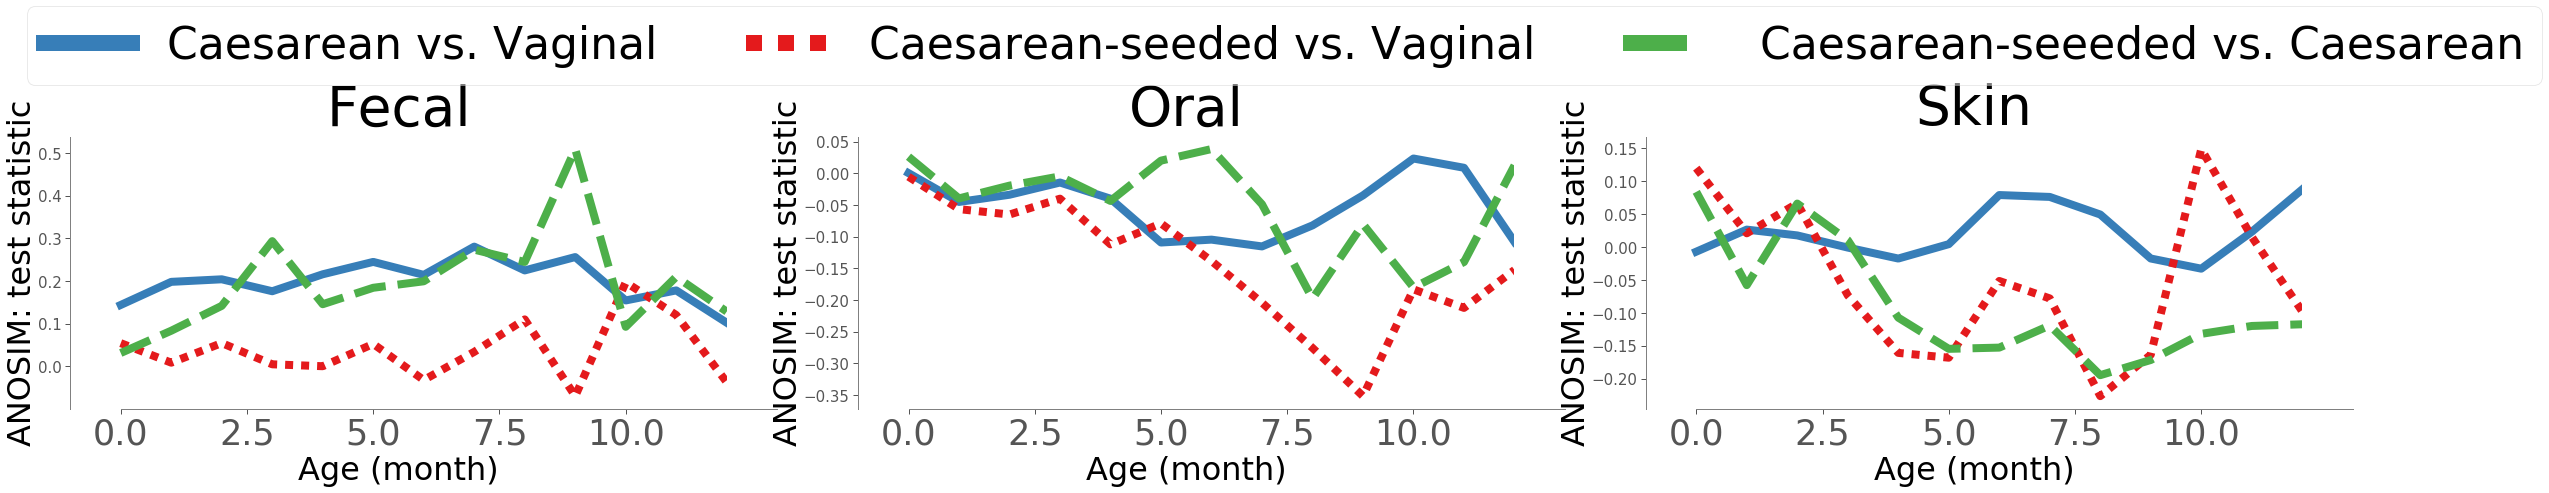

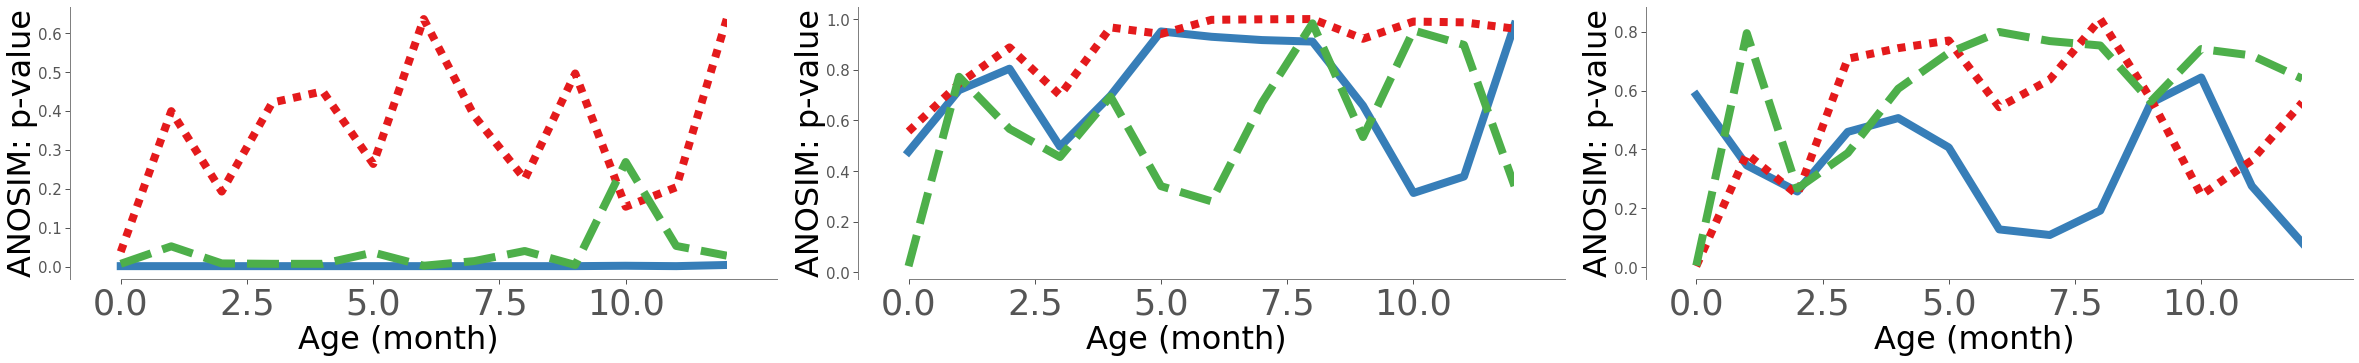

In [23]:
# set label font-sizes globally
paper_rc = {'lines.linewidth': 8, 
            'lines.markersize': 10}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 35 
plt.rcParams['ytick.labelsize'] = 15

labels_map = {'test statistic':'a','p-value':'b'}

for value_ in ['test statistic','p-value']:

    fig, axn = plt.subplots(1,3, figsize=(40,5))

    color_by = 'compare'
    time_ = 'timepoint'
    cmap_bm = {'CS vs. Vag':'#377eb8',
               'CSseed vs. CS':'#4daf4a',
               'CSseed vs. Vag':'#e41a1c'}

    stypes = ['fecal','oral','skin']
    for stype_, ax, value_y in zip(stypes,
                                   axn.flatten(),
                                   [value_, value_, value_]):

        sub_trajs_plot = permanova_res[permanova_res.sample_type.isin([stype_])].copy()
        sub_trajs_plot = sub_trajs_plot[sub_trajs_plot[time_] < 360.0]
        sub_trajs_plot[time_] = sub_trajs_plot[time_].astype(int)
        sub_trajs_plot[value_] = sub_trajs_plot[value_].astype(float)
        sub_trajs_plot['compare'] = sub_trajs_plot['compare_1'] + \
                                    ' vs. ' + sub_trajs_plot['compare_2']
        PC_label = 'ANOSIM: ' + value_
        
        if value_ != 'p-value':
            title_ = stype_.capitalize()
        else:
            title_ = ''

        ax = temporal_plot(time_, value_y, sub_trajs_plot, ax, title_ ,
                           'Age (month)', PC_label, 55, 32, 32,
                           hue=color_by, style=color_by, min_x=0,
                           max_x = 13.0, err_style='bars',
                           ci=68, cmap=cmap_bm,
                           style_order_ = ['CS vs. Vag',
                                           'CSseed vs. CS',
                                           'CSseed vs. Vag'])
        
        ax.set_xlim(-1.0, 12.0)

    # generate legend from last iterations    
    fix_labels = {'CS vs. Vag':'Caesarean vs. Vaginal',
                  'CSseed vs. CS':' Caesarean-seeeded vs. Caesarean',
                  'CSseed vs. Vag':'Caesarean-seeded vs. Vaginal'}
    if value_ != 'p-value':
        handles, labels = ax.get_legend_handles_labels()
        legend = ax.legend(handles[1:],
                           [fix_labels[l] for l in labels[1:]],
                           loc=2, 
                           bbox_to_anchor=(-2.5, 1.56),
                           prop={'size':44},
                           fancybox=True, framealpha=0.5, 
                           ncol=3, markerscale=3, facecolor="white")
        # increase the line width in the legend 
        for line in legend.get_lines()[:]:
            line.set_linewidth(16.0)
        for line in legend.get_lines()[:]:
            line.set_linewidth(16.0)

    # set the backrounf to be transparent
    fig.patch.set_facecolor('white')
    fig.patch.set_alpha(0.0)

    
    plt.savefig('../results/Extended-Data-Figure-2-%s.pdf' % labels_map[value_],
                dpi=1000, 
                bbox_inches='tight',
                facecolor=fig.get_facecolor(), 
                edgecolor='none')
    

    plt.show()
